発話音声に含まれる周波数をヒストグラムで可視化します．
主要な周波数帯をバンドパスで通してやれば，発話としてクリティカルな部分にフォーカスできるため，認識精度が向上するんじゃないかな…？

In [1]:
# 環境構築
!pip install librosa ipython numpy matplotlib japanize-matplotlib scipy soundfile speechbrain -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 29.9 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

WAV_PAIR_LIST_DIR = "/content/drive/MyDrive/CS_seminar/8th/data/list"
PWD = "/content/drive/MyDrive/CS_seminar/8th"

import librosa
import numpy as np
import os
from matplotlib import pyplot as plt
import IPython
from scipy import signal
import soundfile
import itertools
import japanize_matplotlib

%cd /content/drive/MyDrive/CS_seminar/8th/
import eer_pipeline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS_seminar/8th


hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

In [5]:
%cd /content/

/content


音声ファイルのパスを得る
出力してあるリスト->setに変換する

In [6]:
# 発話ペアリストを読む
wav_path_pc = set()
wav_path_sp = set()

def get_wav_path_set(pair_list_path: str) -> set:
  ret_set = set()
  with open(pair_list_path, 'r') as list_file:
    lines = list_file.readlines()
    for line in lines:
      items = line.split(' ')
      ret_set.add(items[1])
      ret_set.add(items[2].rstrip('\n'))
  return ret_set


wav_path_pc = get_wav_path_set(f"{WAV_PAIR_LIST_DIR}/pc.txt")
print(f"wav_path_pc size: {len(wav_path_pc)}") # 49, 発話数と一致．

wav_path_sp = get_wav_path_set(f"{WAV_PAIR_LIST_DIR}/sp.txt")
print(f"wav_path_pc size: {len(wav_path_sp)}") # 49, 発話数と一致．

wav_path_pc size: 49
wav_path_pc size: 49


いくらかバンドパスをかけてみる

関数本体はniwa先輩の実装をお借りしました．お忙しい中ありがとうございます．

In [7]:
# wave: フィルタをかけたい音声
# fs: サンプリング周波数(今回は16000)
# fe: ローパスフィルタの場合はfeよりも低い周波数成分を通す
#     ハイパスフィルタの場合はfeよりも高い周波数成分を通す
#     バンドパスフィルタの場合はfe1以上fe2以下の周波数成分を通す
# n: フィルタの次数(あんまり気にしないで良いです)

# ローパスフィルタ
def lpf(wave, fs, fe, n):
    nyq = fs / 2.0
    b, a = signal.butter(1, fe/nyq, btype='low')
    for i in range(0, n):
        wave = signal.filtfilt(b, a, wave)
    return wave


# ハイパスフィルタ
def hpf(wave, fs, fe, n):
    nyq = fs / 2.0
    b, a = signal.butter(1, fe/nyq, btype='high')
    for i in range(0, n):
        wave = signal.filtfilt(b, a, wave)
    return wave


# バンドパスフィルタ
def bpf(wave, fs, fe1, fe2, n):
    nyq = fs / 2.0
    b, a = signal.butter(1, [fe1/nyq, fe2/nyq], btype='band')
    for i in range(0, n):
        wave = signal.filtfilt(b, a, wave)
    return wave

In [8]:
def is_same_speaker(path1, path2):
  # path文字列を解析して，パス対が同じ話者であるかを判定
  name1 = path1.split('/')[-3]
  name2 = path2.split('/')[-3]
  # # re(正規表現)による実装．今回のpathであればsplit('/')でいいが，複雑な区切り文字とかになると正規表現を用いた方が良い場面も出てくる．
  # dir1 = re.match(r"(.*/).+\.wav", path1).group(1)
  # dir2 = re.match(r"(.*/).+\.wav", path2).group(1)
  return int(name1 == name2)

def gen_2pair_listfile(path_list, outfile_path):
  outfile = open(outfile_path, 'w')
  out_info = {
      "filename": outfile_path,
      "total_wavs": len(path_list),
      "total_pairs": len(path_list) * (len(path_list)-1) // 2,
      "same_pair": 0,
      "diff_pair": 0,
  }
  # itertools.combinations()による実装．
  # 組み合わせをforで構築するのは，`CS_seminar/4th/*/gen_list.py`を参照のこと．
  pairs = list(itertools.combinations(path_list, 2))
  for pair in pairs:
    same_spk = is_same_speaker(*pair)
    outstr = f"{same_spk} {pair[0]} {pair[1]}\n"
    outfile.write(outstr)
    # ペア数を記録
    if same_spk:
      out_info["same_pair"] += 1
    else:
      out_info["diff_pair"] += 1
  outfile.close()
  return out_info

def bpf_pipeline(wav_path_list: list[str], bpf_range: tuple, out_list_path: str) -> None:
  filted_wav_path = []
  for wav_path in wav_path_list:
    wave_vanilla, sr = librosa.load(wav_path, sr=16000)
    new_file_name = f"{wav_path[:-4]}_{bpf_range[0]}-{bpf_range[1]}.wav"
    wave_filt = bpf(
        wave_vanilla,
        fs=sr,
        fe1=bpf_range[0], fe2=bpf_range[1],
        n=5
    )
    # print(new_file_name)
    soundfile.write(
        file=new_file_name,
        data=wave_filt,
        samplerate=sr
    )
    filted_wav_path.append(new_file_name)

    gen_2pair_listfile(filted_wav_path, out_list_path)

In [9]:
def save_spectrogram(wav_path: str, outfile_path: str) -> None:
  #FFT点数
  n_fft = 2048
  #窓長
  win_length = 1024
  #シフト量
  hop_length = win_length//4
  #音声ロード
  x, sr = librosa.load(wav_path, sr=16000)
  #短時間フーリエ変換
  D = librosa.stft(x, n_fft=n_fft, win_length=win_length, hop_length=hop_length)

  #Dは複素数なので絶対値をとって振幅を得る
  S = np.abs(D)

  #デシベルに変換
  db = librosa.amplitude_to_db(S, ref=np.max)

  #スペクトログラム表示
  fig, ax = plt.subplots()
  img = librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='linear')
  ax.set_title("スペクトログラム", fontsize=18) #タイトルの設定,なんかフォントサイズが小さかったのでサイズを変更
  ax.set_xlabel("時間(s)") #x軸の設定
  ax.set_ylabel("周波数(Hz)") #y軸の設定
  plt.savefig(outfile_path, dpi=600)

---


In [10]:
%cd /content/

/content


## 100~1000Hz

In [11]:
bpf_range = (100, 1000)

bpf_pipeline(list(wav_path_pc), bpf_range, f"{PWD}/data/list/pc_100-1000.txt")
bpf_pipeline(list(wav_path_sp), bpf_range, f"{PWD}/data/list/sp_100-1000.txt")

### pc


100%|██████████| 1176/1176 [00:45<00:00, 25.87it/s]


wav_list:/content/drive/MyDrive/CS_seminar/8th/data/list/pc_100-1000.txt
pairs:1176
eer: 0.2644003777135333
eer_th: 0.3322522640229151
FalseNegatives(eer_th:0.3322522640229151)
score:0.32605957984924316 /content/drive/MyDrive/CS_seminar/8th/data/wav/ktg/pc/ktg_pc_04_100-1000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ktg/pc/ktg_pc_05_100-1000.wav
score:0.1642790138721466 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_04_100-1000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_02_100-1000.wav
score:0.27309858798980713 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_05_100-1000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_01_100-1000.wav
score:0.25926584005355835 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_05_100-1000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_03_100-1000.wav
score:0.24520628154277802 /content/drive/MyDrive/CS_seminar/8th/

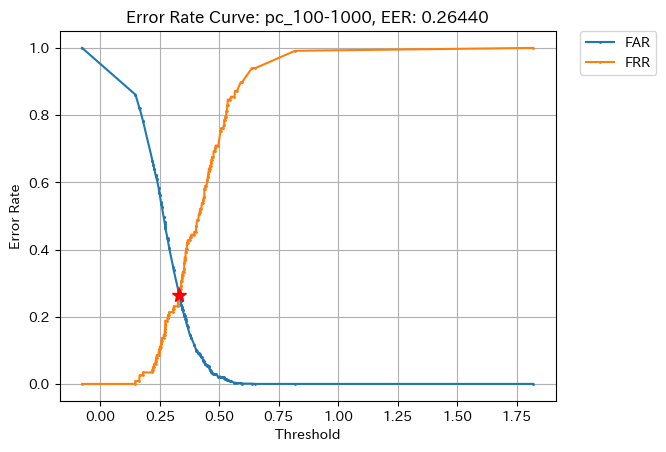

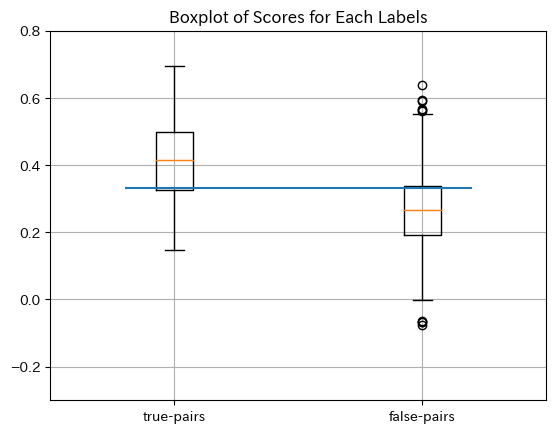

In [12]:
eer_pipeline.eer_roc_pipeline(f"{PWD}/data/list/pc_100-1000.txt", PWD)

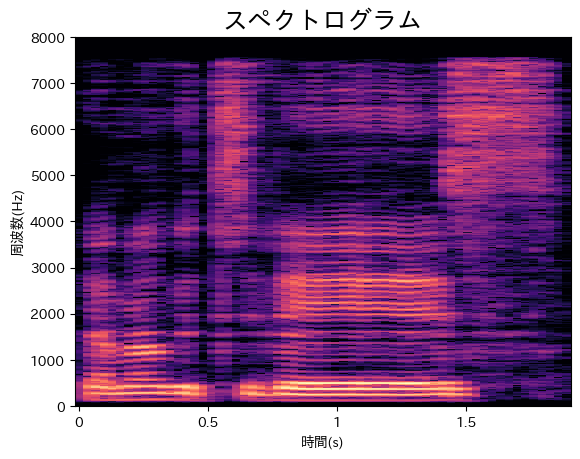

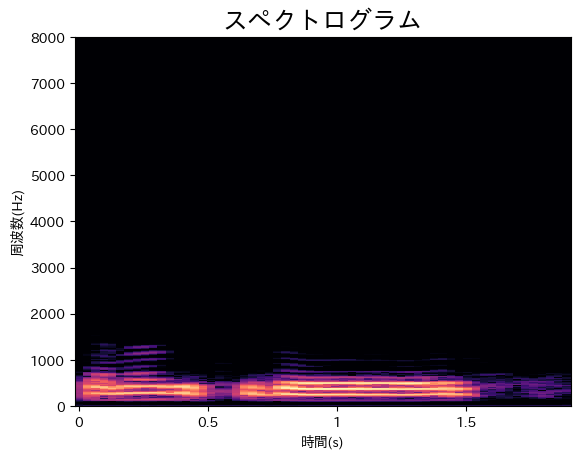

In [13]:
save_spectrogram(
    "/content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_01.wav",
    f"{PWD}/fig/pc_100-1000/vanilla.png"
)
save_spectrogram(
    "/content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_01_100-1000.wav",
    f"{PWD}/fig/pc_100-1000/bpfed.png"
)

### sp

100%|██████████| 1176/1176 [00:42<00:00, 27.66it/s]


wav_list:/content/drive/MyDrive/CS_seminar/8th/data/list/sp_100-1000.txt
pairs:1176
eer: 0.21367521367521375
eer_th: 0.3274594596771649
FalseNegatives(eer_th:0.3274594596771649)
score:0.28740257024765015 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_B/sp/ymgt-B_sp_03_100-1000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_B/sp/ymgt-B_sp_04_100-1000.wav
score:0.32253092527389526 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_E/sp/ymgt-E_sp_03_100-1000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_E/sp/ymgt-E_sp_04_100-1000.wav
score:0.21556101739406586 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_E/sp/ymgt-E_sp_03_100-1000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_E/sp/ymgt-E_sp_02_100-1000.wav
score:0.20687296986579895 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_F/sp/ymgt-F_sp_06_100-1000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_F/sp/ymgt-F_sp_04_100-1000.wav
score:0.2145267128944397 /content/drive/MyDrive/CS

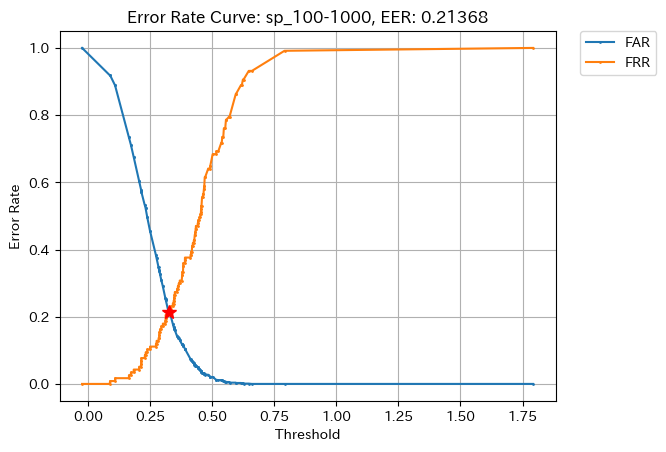

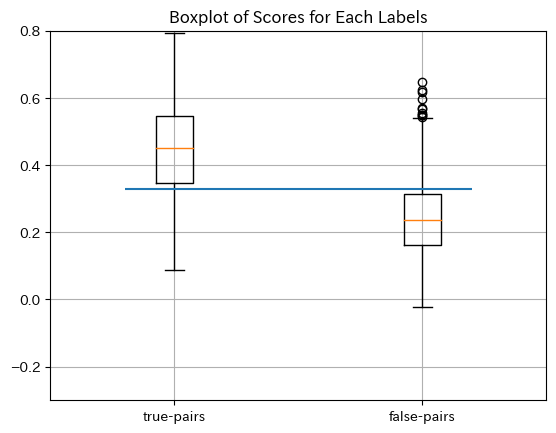

In [14]:
eer_pipeline.eer_roc_pipeline(f"{PWD}/data/list/sp_100-1000.txt", PWD)

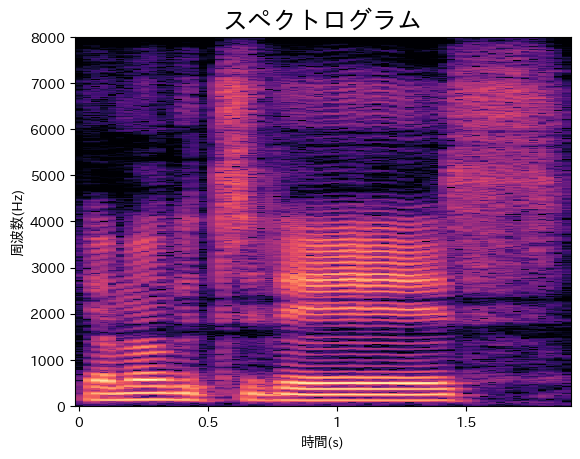

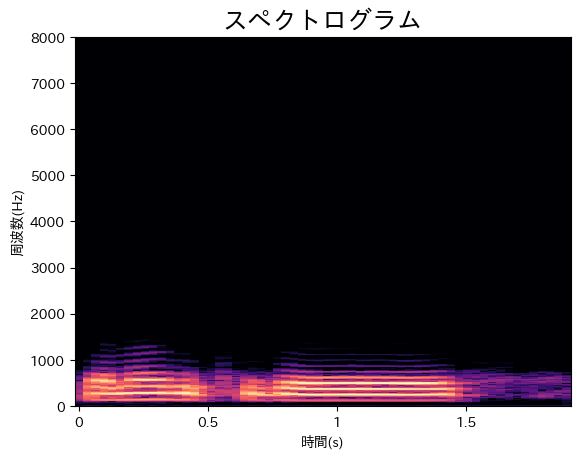

In [15]:
save_spectrogram(
    "/content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/sp/ymgt-A_sp_01.wav",
    f"{PWD}/fig/sp_100-1000/vanilla.png"
)
save_spectrogram(
    "/content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/sp/ymgt-A_sp_01_100-1000.wav",
    f"{PWD}/fig/sp_100-1000/bpfed.png"
)

## 300~3400
電話の周波数帯がコレなので．

In [16]:
bpf_range = (300, 3400)

bpf_pipeline(list(wav_path_pc), bpf_range, f"{PWD}/data/list/pc_300-3400.txt")
bpf_pipeline(list(wav_path_sp), bpf_range, f"{PWD}/data/list/sp_300-3400.txt")

### pc


100%|██████████| 1176/1176 [00:44<00:00, 26.52it/s]


wav_list:/content/drive/MyDrive/CS_seminar/8th/data/list/pc_300-3400.txt
pairs:1176
eer: 0.2307692307688651
eer_th: 0.18235608247621285
FalseNegatives(eer_th:0.18235608247621285)
score:0.1791025698184967 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_05_300-3400.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_03_300-3400.wav
score:0.1664050668478012 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_B/pc/ymgt-B_pc_07_300-3400.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_B/pc/ymgt-B_pc_04_300-3400.wav
score:0.1602807193994522 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_F/pc/ymgt-F_pc_06_300-3400.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_F/pc/ymgt-F_pc_04_300-3400.wav
score:0.14482393860816956 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_01_300-3400.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_02_300-3400.wav
score:0.14268618822097778 /content/drive/MyDrive/CS_

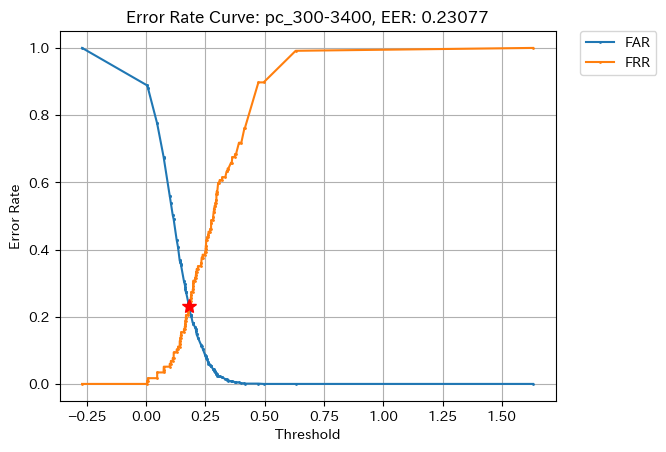

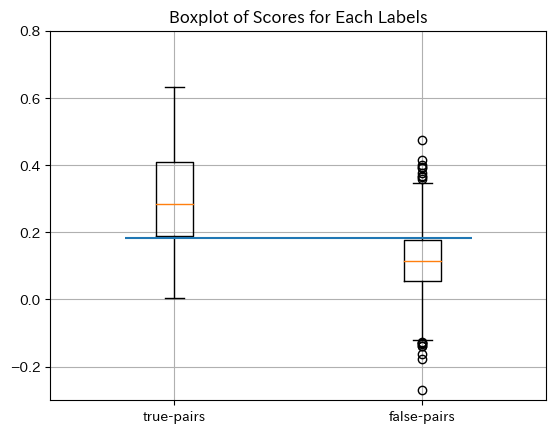

In [17]:
eer_pipeline.eer_roc_pipeline(f"{PWD}/data/list/pc_300-3400.txt", PWD)

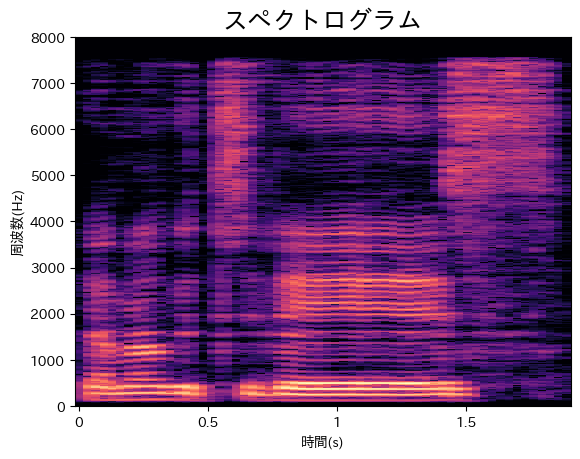

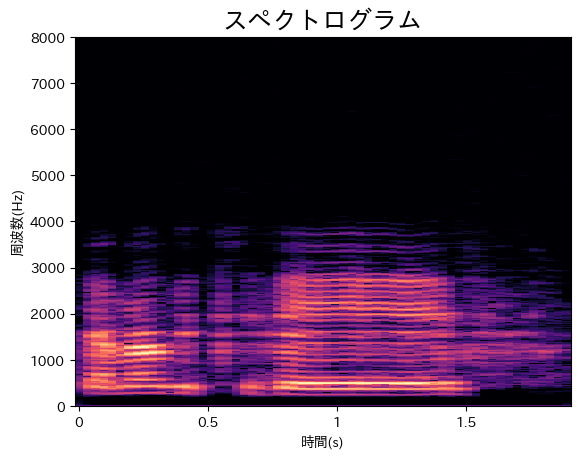

In [18]:
save_spectrogram(
    "/content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_01.wav",
    f"{PWD}/fig/pc_300-3400/vanilla.png"
)
save_spectrogram(
    "/content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_01_300-3400.wav",
    f"{PWD}/fig/pc_300-3400/bpfed.png"
)

### sp

100%|██████████| 1176/1176 [00:42<00:00, 27.46it/s]


wav_list:/content/drive/MyDrive/CS_seminar/8th/data/list/sp_300-3400.txt
pairs:1176
eer: 0.17948717948717954
eer_th: 0.20703004331855504
FalseNegatives(eer_th:0.20703004331855504)
score:0.17842748761177063 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_B/sp/ymgt-B_sp_03_300-3400.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_B/sp/ymgt-B_sp_05_300-3400.wav
score:0.18124544620513916 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_B/sp/ymgt-B_sp_03_300-3400.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_B/sp/ymgt-B_sp_07_300-3400.wav
score:0.16017216444015503 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_E/sp/ymgt-E_sp_03_300-3400.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_E/sp/ymgt-E_sp_02_300-3400.wav
score:0.19442644715309143 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_F/sp/ymgt-F_sp_06_300-3400.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_F/sp/ymgt-F_sp_02_300-3400.wav
score:0.2035258561372757 /content/drive/MyDrive/

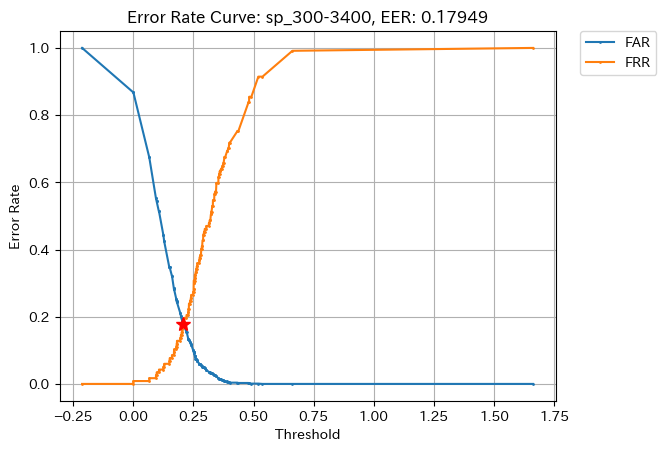

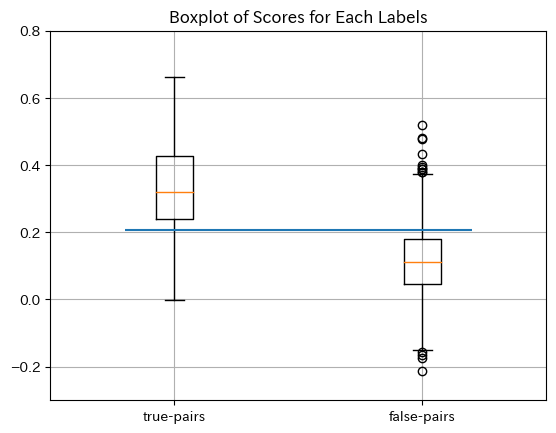

In [19]:
eer_pipeline.eer_roc_pipeline(f"{PWD}/data/list/sp_300-3400.txt", PWD)

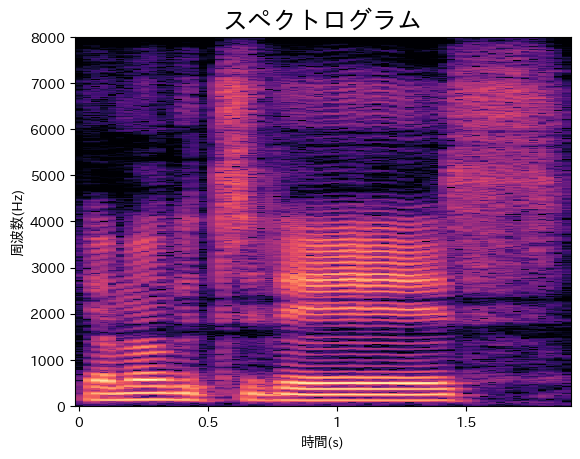

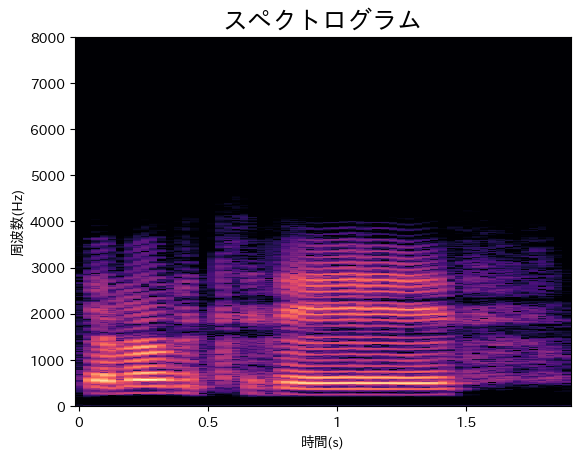

In [20]:
save_spectrogram(
    "/content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/sp/ymgt-A_sp_01.wav",
    f"{PWD}/fig/sp_300-3400/vanilla.png"
)
save_spectrogram(
    "/content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/sp/ymgt-A_sp_01_300-3400.wav",
    f"{PWD}/fig/sp_300-3400/bpfed.png"
)

## 3000~6000
ためしにやってみる．なんとかなれ～っ！！


In [21]:
bpf_range = (3000, 6000)

bpf_pipeline(list(wav_path_pc), bpf_range, f"{PWD}/data/list/pc_3000-6000.txt")
bpf_pipeline(list(wav_path_sp), bpf_range, f"{PWD}/data/list/sp_3000-6000.txt")

### pc


100%|██████████| 1176/1176 [00:43<00:00, 26.97it/s]


wav_list:/content/drive/MyDrive/CS_seminar/8th/data/list/pc_3000-6000.txt
pairs:1176
eer: 0.4188034188034187
eer_th: 0.39037149329470777
FalseNegatives(eer_th:0.39037149329470777)
score:0.17003649473190308 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_04_3000-6000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_03_3000-6000.wav
score:0.3434133231639862 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_05_3000-6000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_01_3000-6000.wav
score:0.0997556522488594 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_05_3000-6000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_03_3000-6000.wav
score:0.32573050260543823 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_B/pc/ymgt-B_pc_02_3000-6000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_B/pc/ymgt-B_pc_07_3000-6000.wav
score:0.3837815523147583 /content/drive/My

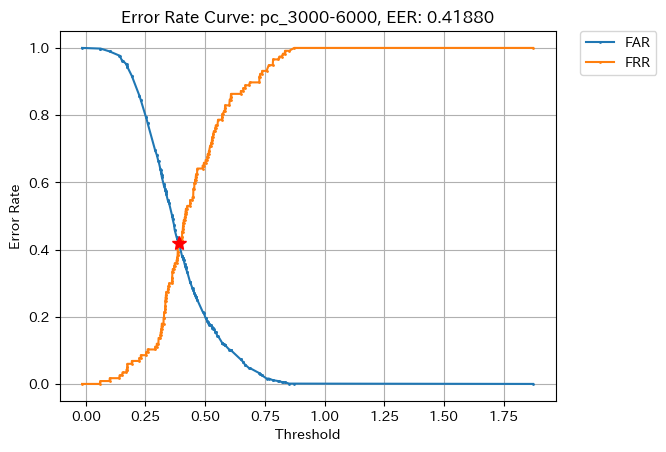

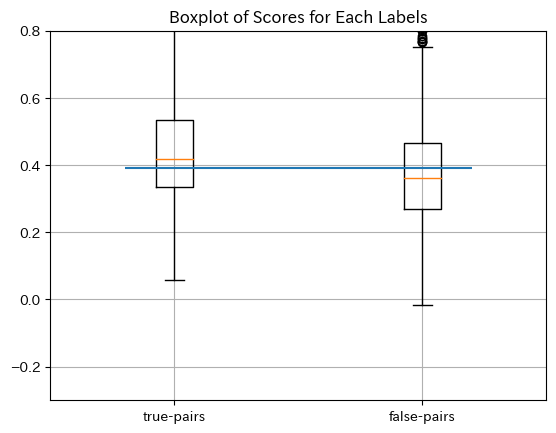

In [22]:
eer_pipeline.eer_roc_pipeline(f"{PWD}/data/list/pc_3000-6000.txt", PWD)

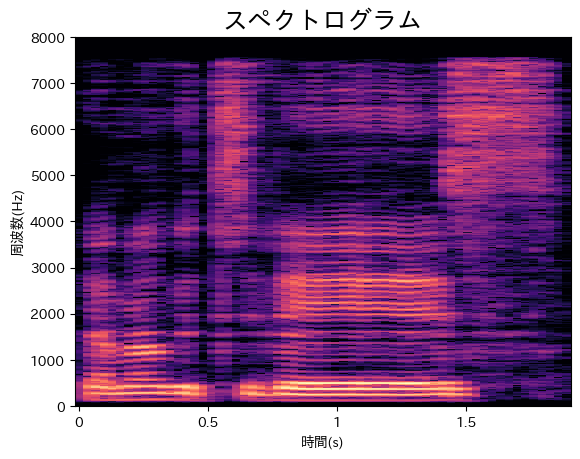

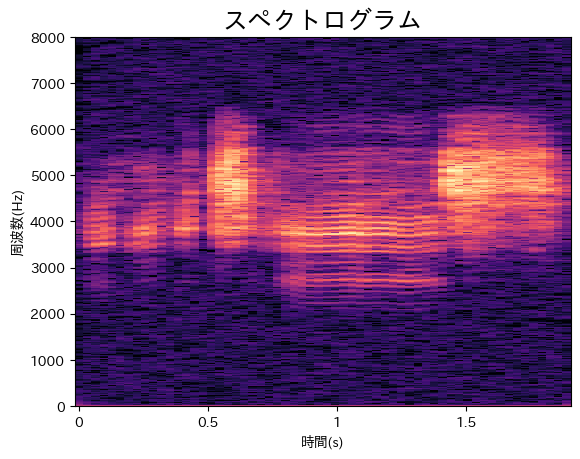

In [23]:
save_spectrogram(
    "/content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_01.wav",
    f"{PWD}/fig/pc_3000-6000/vanilla.png"
)
save_spectrogram(
    "/content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/pc/ymgt-A_pc_01_3000-6000.wav",
    f"{PWD}/fig/pc_3000-6000/bpfed.png"
)

### sp


100%|██████████| 1176/1176 [00:43<00:00, 27.34it/s]


wav_list:/content/drive/MyDrive/CS_seminar/8th/data/list/sp_3000-6000.txt
pairs:1176
eer: 0.3928234183186765
eer_th: 0.43700343370452005
FalseNegatives(eer_th:0.43700343370452005)
score:0.32351773977279663 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_E/sp/ymgt-E_sp_03_3000-6000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_E/sp/ymgt-E_sp_01_3000-6000.wav
score:0.38016974925994873 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_E/sp/ymgt-E_sp_03_3000-6000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_E/sp/ymgt-E_sp_06_3000-6000.wav
score:0.40344953536987305 /content/drive/MyDrive/CS_seminar/8th/data/wav/tmng/sp/tm_sp1_3000-6000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/tmng/sp/tm_sp3_3000-6000.wav
score:0.2994728684425354 /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_E/sp/ymgt-E_sp_04_3000-6000.wav, /content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_E/sp/ymgt-E_sp_01_3000-6000.wav
score:0.37877851724624634 /content/drive/MyDrive/CS_semin

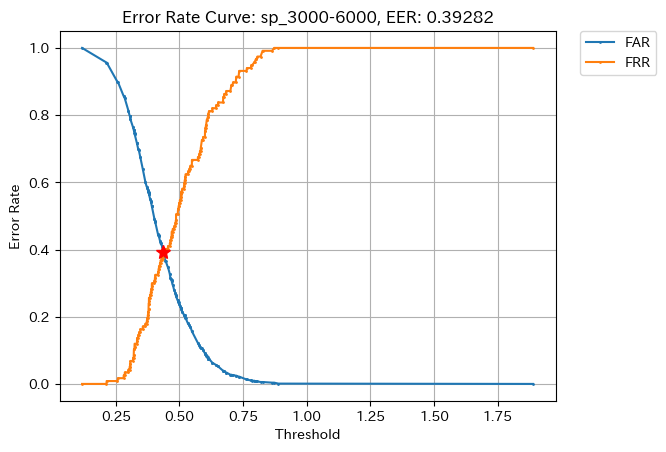

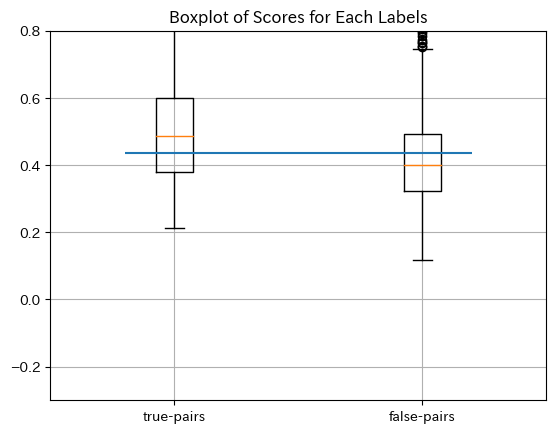

In [24]:
eer_pipeline.eer_roc_pipeline(f"{PWD}/data/list/sp_3000-6000.txt", PWD)

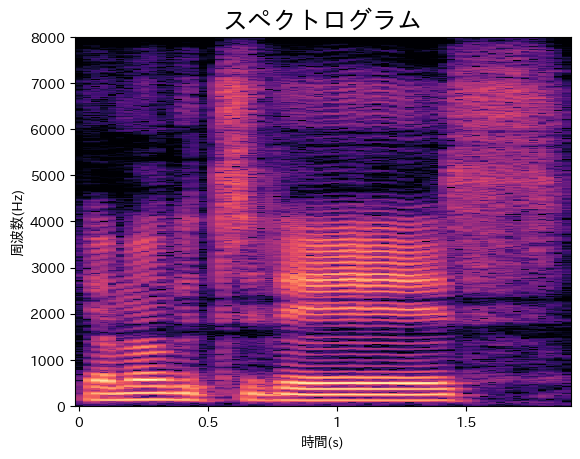

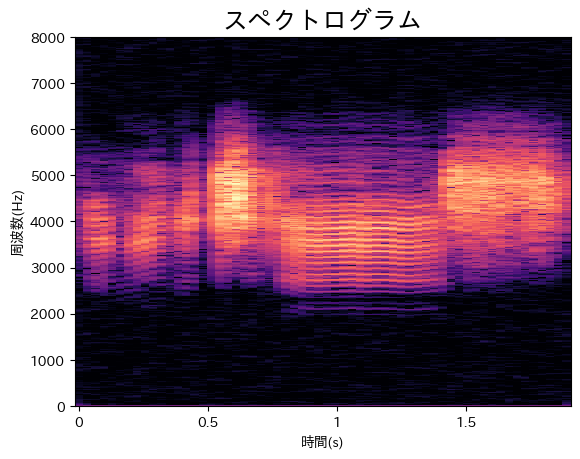

In [25]:
save_spectrogram(
    "/content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/sp/ymgt-A_sp_01.wav",
    f"{PWD}/fig/sp_3000-6000/vanilla.png"
)
save_spectrogram(
    "/content/drive/MyDrive/CS_seminar/8th/data/wav/ymgt_A/sp/ymgt-A_sp_01_3000-6000.wav",
    f"{PWD}/fig/sp_3000-6000/bpfed.png"
)

---
